ModuleNotFoundError: No module named 'google.colab'

In [24]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
import tensorflow as tr
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [25]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'dataset/'
width=256
height=256
depth=3
print(listdir(directory_root))

['Vegetable Images']


In [26]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [27]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for veggie_folder in root_dir :
        temp_list = listdir(f"{directory_root}/{veggie_folder}")
        
        for element in temp_list :
            # remove .DS_Store from list
            if element == ".DS_Store" :
                temp_list.remove(element)

        for temp in temp_list:
            print(f"[INFO] Processing {temp} ...")
            veggie_image_list = listdir(f"{directory_root}{veggie_folder}/{temp}/")  #/{veggie_folder}
               
            for single_veggie_image in veggie_image_list :
                if single_veggie_image == ".DS_Store" :
                    veggie_image_list.remove(single_veggie_image)

            for image in veggie_image_list[:200]:
                image_directory = f"{directory_root}/{veggie_folder}/{temp}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(temp)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Bean ...
[INFO] Processing Bitter_Gourd ...
[INFO] Processing Bottle_Gourd ...
[INFO] Processing Brinjal ...
[INFO] Processing Broccoli ...
[INFO] Processing Cabbage ...
[INFO] Processing Capsicum ...
[INFO] Processing Carrot ...
[INFO] Processing Cauliflower ...
[INFO] Processing Cucumber ...
[INFO] Processing Papaya ...
[INFO] Processing Potato ...
[INFO] Processing Pumpkin ...
[INFO] Processing Radish ...
[INFO] Processing Tomato ...
[INFO] Image loading completed


In [28]:
image_size = len(image_list)

In [29]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [30]:
print(label_binarizer.classes_)

['Bean' 'Bitter_Gourd' 'Bottle_Gourd' 'Brinjal' 'Broccoli' 'Cabbage'
 'Capsicum' 'Carrot' 'Cauliflower' 'Cucumber' 'Papaya' 'Potato' 'Pumpkin'
 'Radish' 'Tomato']


In [31]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [32]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [33]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [34]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 activation_7 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_6 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 85, 85, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 85, 85, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 85, 85, 64)       

In [36]:
opt = tr.keras.optimizers.legacy.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


C:\Users\hp\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [37]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/25
75/75 [==============================] - 414s 5s/step - loss: 0.6523 - accuracy: 0.2342 - val_loss: 0.6970 - val_accuracy: 0.0850
Epoch 2/25
75/75 [==============================] - 332s 4s/step - loss: 0.2994 - accuracy: 0.3142 - val_loss: 0.3262 - val_accuracy: 0.0933
Epoch 3/25
75/75 [==============================] - 331s 4s/step - loss: 0.2044 - accuracy: 0.4650 - val_loss: 0.3629 - val_accuracy: 0.0767
Epoch 4/25
75/75 [==============================] - 4519s 61s/step - loss: 0.1521 - accuracy: 0.6250 - val_loss: 0.3051 - val_accuracy: 0.1750
Epoch 5/25
75/75 [==============================] - 329s 4s/step - loss: 0.1205 - accuracy: 0.7262 - val_loss: 0.2781 - val_accuracy: 0.2750
Epoch 6/25
75/75 [==============================] - 330s 4s/step - loss: 0.1057 - accuracy: 0.7550 - val_loss: 0.2526 - val_accuracy: 0.3633
Epoch 7/25
75/75 [==============================] - 332s 4s/step - loss: 0.0973 - accuracy: 0.7804 - val_loss: 0.1777 - val_accuracy: 0.5150
Epoch 8/25


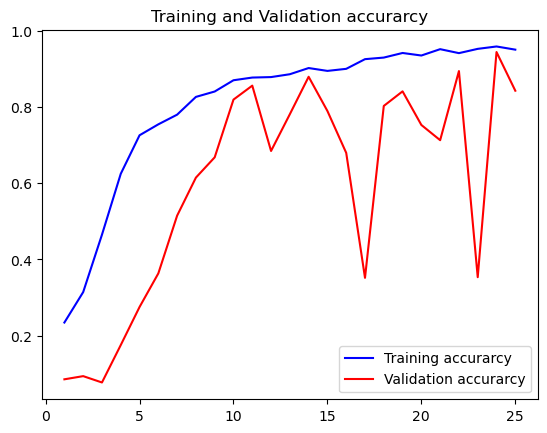

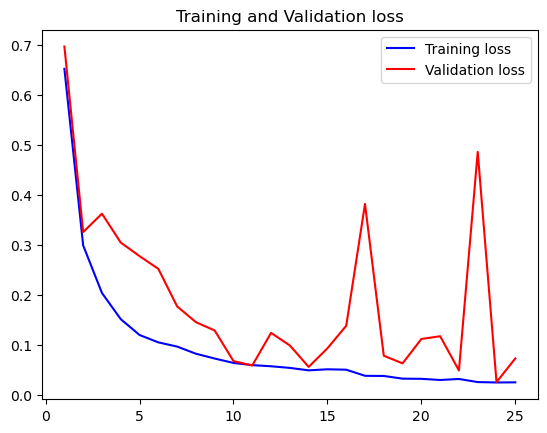

In [38]:
# print(history.params)
# print(history.history)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [39]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 [==============================] - 17s 873ms/step - loss: 0.0736 - accuracy: 0.8433
Test Accuracy: 84.33333039283752


In [48]:
model.save('myModel.h5')

In [49]:
from keras.models import load_model

In [50]:
loaded_model = load_model('myModel.h5')

In [57]:
image_dir="text/ctm.jpg"

im=convert_image_to_array(image_dir)
# print(im)
np_image_li = np.array(im, dtype=np.float16) / 225.0
print(np_image_li)
npp_image = np.expand_dims(np_image_li, axis=0)

[[[0.547   0.573   0.4888 ]
  [0.573   0.6     0.511  ]
  [0.5776  0.6177  0.5244 ]
  ...
  [0.169   0.6665  0.48   ]
  [0.1733  0.6846  0.507  ]
  [0.1823  0.6934  0.5156 ]]

 [[0.6045  0.649   0.547  ]
  [0.6045  0.662   0.547  ]
  [0.609   0.68    0.542  ]
  ...
  [0.169   0.6665  0.48   ]
  [0.1644  0.671   0.4934 ]
  [0.1777  0.676   0.4978 ]]

 [[0.6133  0.676   0.569  ]
  [0.5913  0.671   0.547  ]
  [0.533   0.6357  0.4756 ]
  ...
  [0.16    0.671   0.48   ]
  [0.1555  0.6665  0.4756 ]
  [0.169   0.6665  0.48   ]]

 ...

 [[0.3022  0.7646  0.5645 ]
  [0.3022  0.729   0.5513 ]
  [0.3867  0.7954  0.6265 ]
  ...
  [0.1555  0.7646  0.6045 ]
  [0.2222  0.769   0.6    ]
  [0.2622  0.778   0.622  ]]

 [[0.311   0.742   0.5557 ]
  [0.3289  0.729   0.5557 ]
  [0.4443  0.791   0.6265 ]
  ...
  [0.1378  0.7734  0.6177 ]
  [0.2089  0.7734  0.6177 ]
  [0.2578  0.7734  0.6265 ]]

 [[0.3777  0.782   0.5913 ]
  [0.3955  0.7466  0.582  ]
  [0.5024  0.8047  0.662  ]
  ...
  [0.10223 0.769   0.617

In [58]:
result=model.predict(npp_image)

print(result)

1/1 [==============================] - 0s 181ms/step
[[5.8018889e-13 6.0858735e-13 1.3631253e-15 4.1433850e-14 5.2385568e-11
  6.2994626e-10 3.3080278e-11 6.8325152e-13 2.9186881e-12 5.0201728e-15
  3.0985693e-13 7.5911113e-14 2.3740240e-14 1.9040422e-13 1.0000000e+00]]


In [59]:
itemindex = np.where(result==np.max(result))
for i in itemindex:
    print(i)
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

[0]
[14]
probability:1.0
Tomato
